In [1]:
%matplotlib inline

In [2]:
# %load run.py
from matplotlib import pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import Quandl
from datetime import datetime

# Lee token de Quandl
with open('token.txt', 'rU') as f:
    token = f.readline().rstrip()

# Descarga datos Indicadores
today = datetime.now()
usdclp = Quandl.get("CURRFX/USDCLP", authtoken=token)['Rate']
ipsa = web.DataReader('^IPSA', 'yahoo', start=datetime(2003, 1, 10), end=today)['Close']
spy = web.DataReader('SPY', 'yahoo', start=datetime(1993, 1, 29), end=today)['Close']
eem = web.DataReader('EEM', 'yahoo', start=datetime(2003, 4, 15), end=today)['Close']
vea = web.DataReader('VEA', 'yahoo', start=datetime(2007, 7, 26), end=today)['Close']
stoxx = web.DataReader('^STOXX50E', 'yahoo', start=datetime(1993, 1, 1), end=today)['Close']
# Junta Indicadores en un solo DataFrame
data_index = pd.DataFrame()
data_index['ipsa'] = ipsa
data_index['spy'] = spy
data_index['eem'] = eem
data_index['vea'] = vea
data_index['stoxx'] = stoxx
data_index['usdclp'] = usdclp

# Descarga datos Valores Cuota AFP
karg_csv = dict(delimiter=';', decimal=',', index_col=0, parse_dates=True)
afps = ['CUPRUM', 'HABITAT', 'PLANVITAL', 'PROVIDA', 'MODELO']
data = {}
for afp_name in afps:
    filename = 'https://raw.githubusercontent.com/collabmarket/data_afp/master/data/VC-%s.csv'%afp_name
    data[afp_name] = pd.read_csv(filename, **karg_csv)
# Junta Valores cuota en un Panel
data_afp = pd.Panel(data)

# Crea DataFrame de trabajo
df = data_index.copy()
df['CUPRUM_A'] = data_afp.CUPRUM.A
df.dropna(inplace=True)
# Rentabilidad diaria
df_pct = df.pct_change()

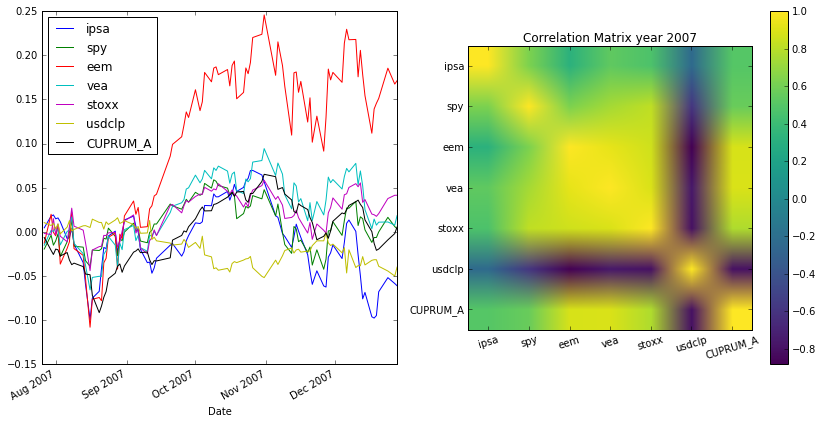

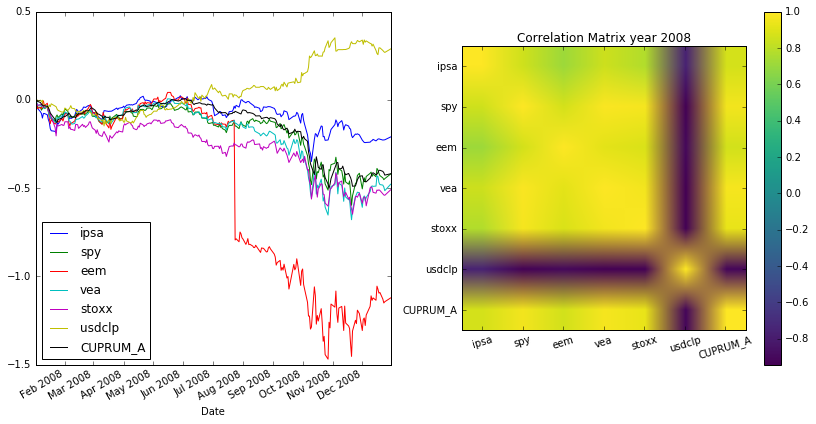

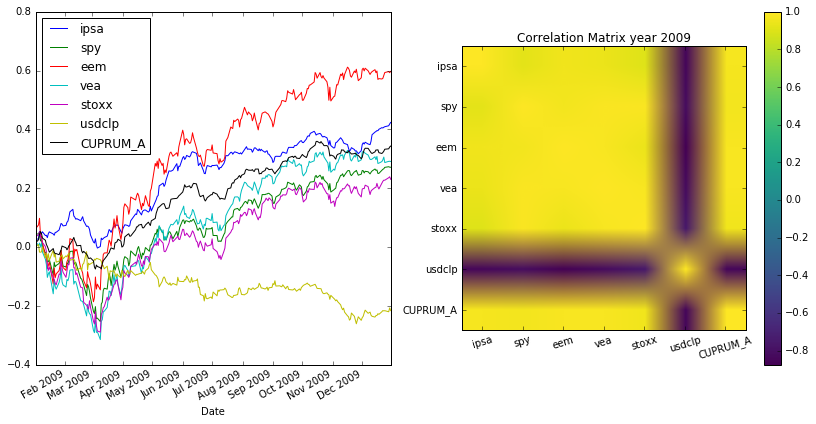

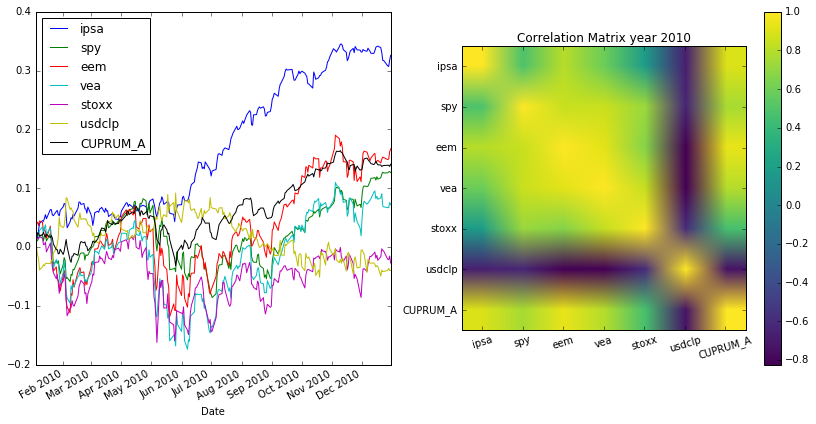

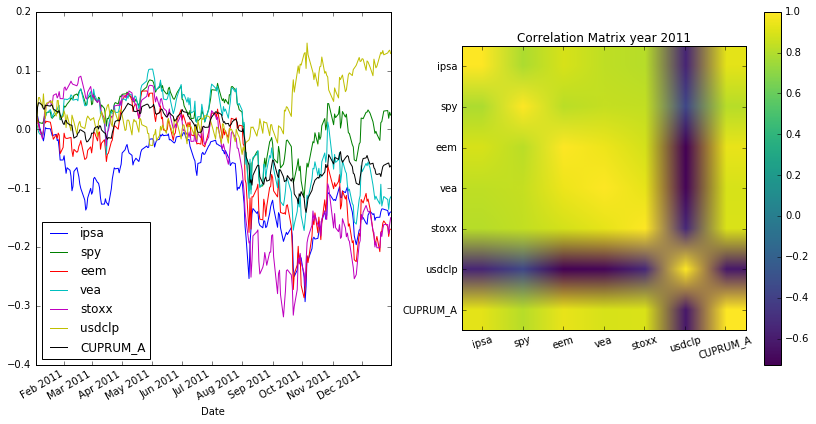

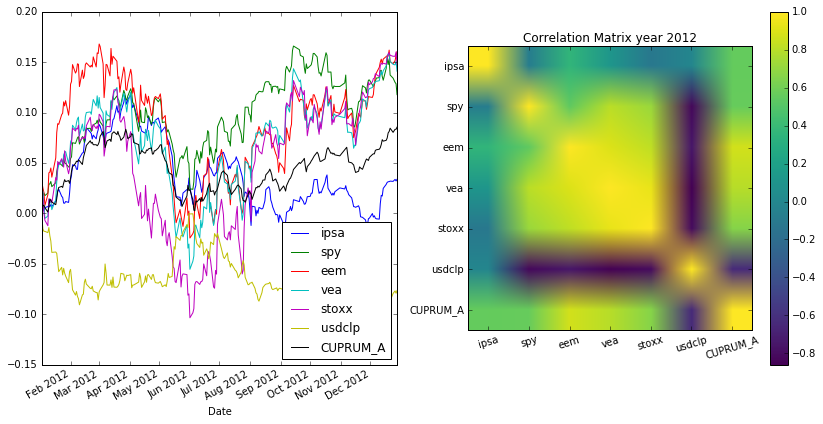

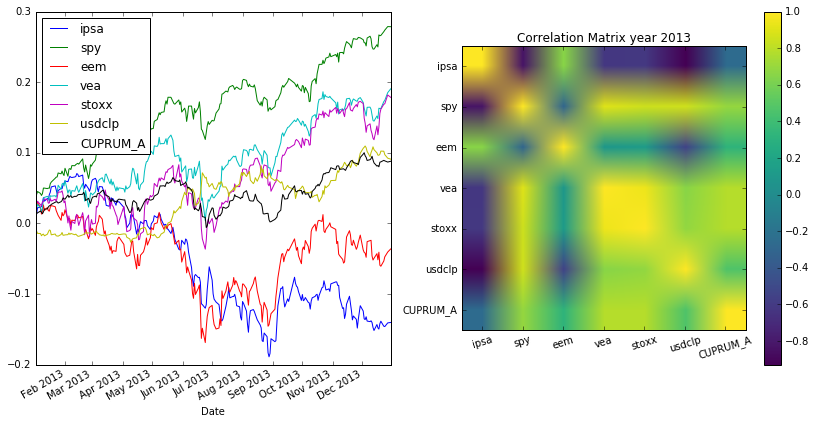

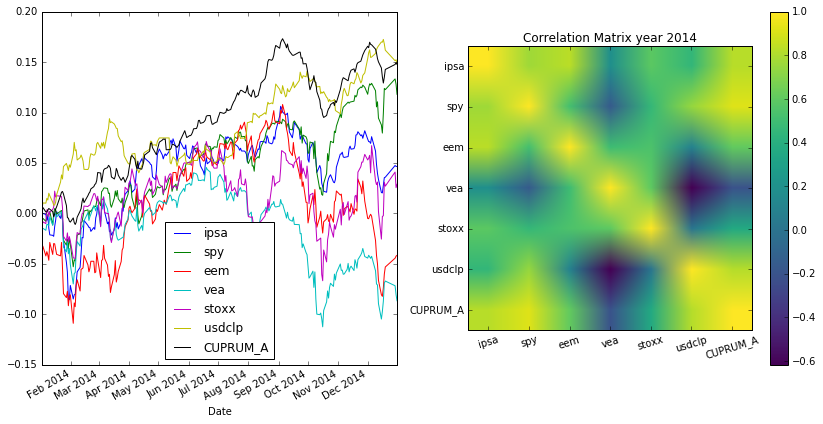

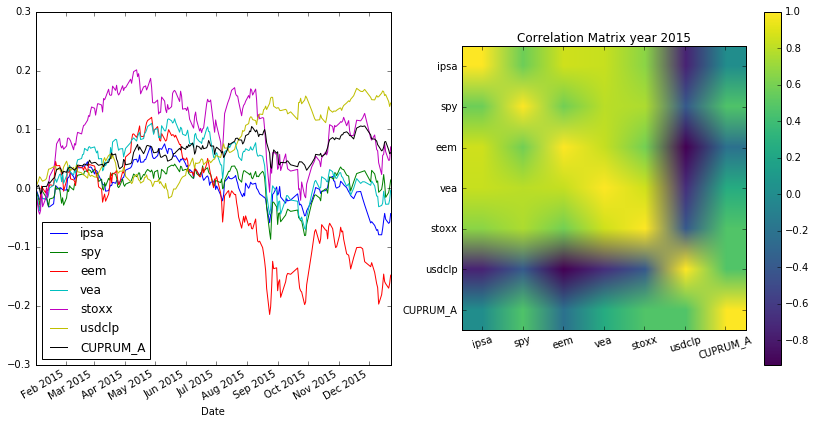

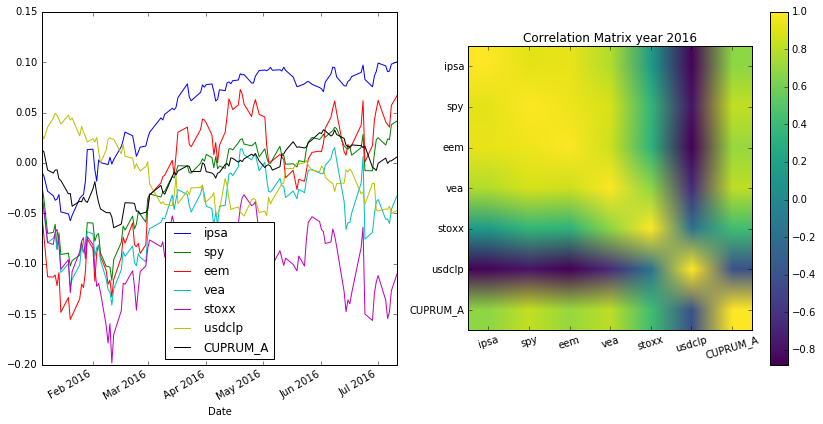

In [3]:
# Matrices de correlacion y rentabilidad acumulada anual
for yr in range(df_pct.index[0].year,df_pct.index[-1].year+1,1):
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(121)
    df_pct[str(yr)].cumsum().plot(ax=ax)
    fig.add_subplot(122)
    plt.imshow(df_pct[str(yr)].cumsum().corr(), cmap='viridis')
    plt.colorbar()
    plt.title('Correlation Matrix year %s'%(yr))
    col = df_pct.columns.values
    plt.xticks(range(col.size), col, rotation=17)
    plt.yticks(range(col.size), col)
    plt.show()

In [4]:
import statsmodels.formula.api as smf

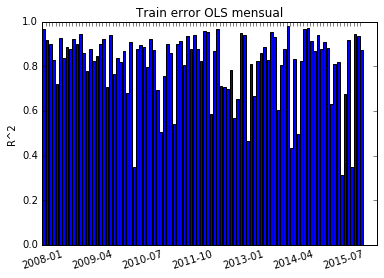

In [5]:
# OLS usando statsmodels
r2 = []
ticks = []
for yr in range(df_pct.index[0].year+1,df_pct.index[-1].year,1):
    for mon in range(1,13):
        period = '%s-%.2d'%(yr,mon)
        result = smf.ols(formula='CUPRUM_A ~ spy + ipsa + eem + vea + stoxx + usdclp', data=df_pct[period].cumsum()).fit()
        #print result.params
        #print 'Period %s R^2: %s'%(period, result.rsquared)
        r2.append(result.rsquared)
        ticks.append(period)

fig = plt.figure()
ax = fig.add_subplot(111)
l_ = len(ticks)
x_ = range(l_)
plt.bar(x_, r2)
plt.title('Train error OLS mensual')
plt.ylabel('R^2')
# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*l_
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
step = int(l_/(width*1.3))
# Every step ticklable shows the month, day and year
ticklabels[::step] = ticks[::step]
plt.xticks(x_, ticklabels, rotation=17)
plt.show()

In [6]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression

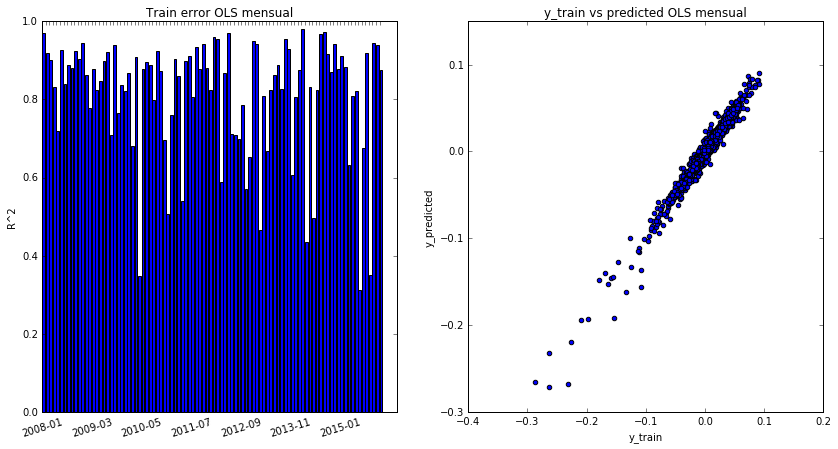

In [7]:
# OLS usando sklearn
r2 = []
ticks = []
y_train = []
y_predicted = []
for yr in range(df_pct.index[0].year+1,df_pct.index[-1].year,1):
    for mon in range(1,13):
        period = '%s-%.2d'%(yr,mon)
        y, X = dmatrices('CUPRUM_A ~ spy + ipsa + eem + vea + stoxx + usdclp', df_pct[period].cumsum())
        clf = LinearRegression()
        clf.fit(X, y)
        #print clf.coef_
        #print 'Period %s R^2: %s'%(period, clf.score(X, y))
        r2.append(clf.score(X, y))
        ticks.append(period)
        y_train += list(y.ravel())
        y_predicted += list(clf.predict(X).ravel())

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
l_ = len(ticks)
x_ = range(l_)
plt.bar(x_, r2)
plt.title('Train error OLS mensual')
plt.ylabel('R^2')
# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*l_
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
step = int(l_/(width*1.3))
# Every step ticklable shows the month, day and year
ticklabels[::step] = ticks[::step]
plt.xticks(x_, ticklabels, rotation=17)
# Plot y_test vs predicted
ax = fig.add_subplot(122)
ax.scatter(y_train, y_predicted)
plt.title('y_train vs predicted OLS mensual')
plt.xlabel('y_train')
plt.ylabel('y_predicted')
plt.show()

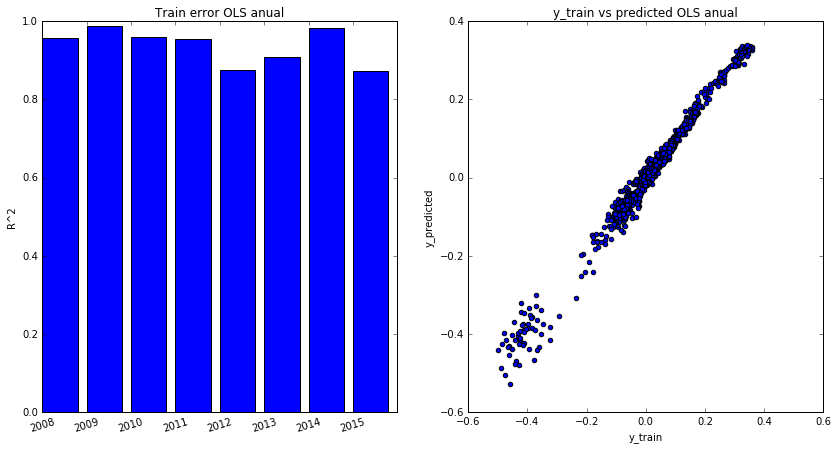

In [8]:
r2 = []
ticks = []
y_train = []
y_predicted = []
for yr in range(df_pct.index[0].year+1,df_pct.index[-1].year,1):
    period = '%s'%(yr)
    y, X = dmatrices('CUPRUM_A ~ spy + ipsa + eem + vea + stoxx + usdclp', df_pct[period].cumsum())
    clf = LinearRegression()
    clf.fit(X, y)
    #print clf.coef_
    #print 'Period %s R^2: %s'%(period, clf.score(X, y))
    r2.append(clf.score(X, y))
    ticks.append(period)
    y_train += list(y.ravel())
    y_predicted += list(clf.predict(X).ravel())

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
l_ = len(ticks)
x_ = range(l_)
plt.bar(x_, r2)
plt.title('Train error OLS anual')
plt.ylabel('R^2')
# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*l_
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
step = int(l_/(width*1.3))
# Every step ticklable shows the year
ticklabels[::step] = ticks[::step]
plt.xticks(x_, ticklabels, rotation=17)
# Plot y_test vs predicted
ax = fig.add_subplot(122)
ax.scatter(y_train, y_predicted)
plt.title('y_train vs predicted OLS anual')
plt.xlabel('y_train')
plt.ylabel('y_predicted')
plt.show()

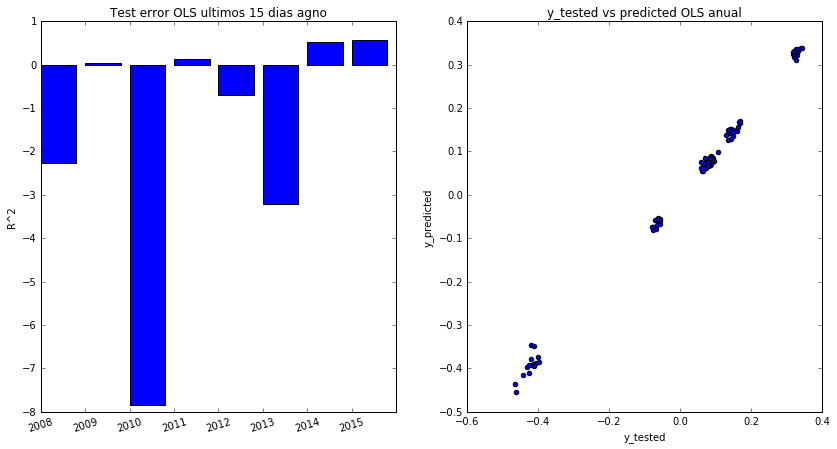

In [9]:
# Ultimos p dias del agno
p = -15
r2 = []
ticks = []
y_tested = []
y_predicted = []
for yr in range(df_pct.index[0].year+1,df_pct.index[-1].year,1):
    period = '%s'%(yr)
    y, X = dmatrices('CUPRUM_A ~ spy + ipsa + eem + vea + stoxx + usdclp', df_pct[period].cumsum())
    X_train = X[:p]
    X_test = X[p:]
    y_train = y[:p]
    y_test = y[p:]
    clf = LinearRegression()
    clf.fit(X, y)
    #print clf.coef_
    #print 'Period %s R^2: %s'%(period, clf.score(X, y))
    r2.append(clf.score(X_test, y_test))
    ticks.append(period)
    y_tested += list(y_test.ravel())
    y_predicted += list(clf.predict(X_test).ravel())

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
l_ = len(ticks)
x_ = range(l_)
plt.bar(x_, r2)
plt.title('Test error OLS ultimos %s dias agno'%abs(p))
plt.ylabel('R^2')
# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*l_
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = bbox.width, bbox.height
step = int(l_/(width*1.3))
# Every step ticklable shows the year
ticklabels[::step] = ticks[::step]
plt.xticks(x_, ticklabels, rotation=17)
# Plot y_test vs predicted
ax = fig.add_subplot(122)
ax.scatter(y_tested, y_predicted)
plt.title('y_tested vs predicted OLS anual')
plt.xlabel('y_tested')
plt.ylabel('y_predicted')
plt.show()

[[ 0.          0.06283268  0.15725837 -0.02425544 -0.09616054  0.06939552
   0.06422187]]
R^2: 0.110472822033


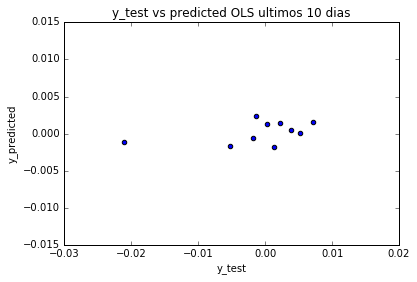

In [10]:
# Ultimos prueba p dias y entrena ultimos d dias
d = -365
p = -10
y, X = dmatrices('CUPRUM_A ~ spy + ipsa + eem + vea + stoxx + usdclp', df_pct[d:])
X_train = X[:p]
X_test = X[p:]
y_train = y[:p]
y_test = y[p:]
clf = LinearRegression()
clf.fit(X_train, y_train)
print clf.coef_
print 'R^2: %s'%(clf.score(X_test, y_test))
predicted = clf.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y_test, predicted)
plt.title('y_test vs predicted OLS ultimos %s dias'%abs(p))
plt.xlabel('y_test')
plt.ylabel('y_predicted')